In [1]:
import numpy as np
from scipy.optimize import curve_fit
from linecache import getline
import os, sys, glob, errno
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from helper_functions import plot_df

In [2]:
sample_name = "T20-5d"
Cu_thickness = 249.28e-9 # in meters
sample_thickness = 323.44e-9 # in meters

In [3]:
from data_class import Data

data = Data(sample_name, Cu_thickness, sample_thickness)

print(data.thermometers)

['LT thermometer', 'HT thermometer']


An outline of the data analysis is as follows:

- **Thermometer Resistance**. The thermometer resistance $R_{th}$ (Pt, low-T NbSi, or high-T NbSi depending on the temperature range) is measured as a function of temperature. The data $T(R_{th})$ is then fit to an appropriate function, so that later the temperature can be determined via measurements of $R_{th}$.
- **Kappa** ($\kappa$). The thermal link, Kappa (in J/K), between the sample and its environment is determined. The first step is to measure $R_{th}$ at a series of heater powers $P$. Then the $T(R_{th})$ curve is used to find $P$ vs $T$, and a value of Kappa at each temperature is calculated as $P/(T-T_0)$ where $T_0$ is the temperature when the heater power is zero.
- **Tau** ($\tau$). Heater power is applied to raise the temperature of the sample above $T_0$, the surrounding block temperature (a typical value is $1.02T_0$). Then the heater power is cut, and the sample's temperature decays exponentially. Since the temperature change relative to $T_0$ is small, the thermometer resistance decay is very close to an exponential as well, and so this is the fit that is done to obtain the decay constant Tau.
- **Outlier removal.** Some simple strategies are used to remove outliers by fairly objective means (with the goal of limiting users from potentially mucking about too much with the data, of course).
- $C_P$. The specific heat at constant pressure, $C_P$, is obtained via $C_P(T) = \kappa(T)\tau(T)$. There are some complications here; the data must be interpolated, and the background (a previously measured device and the heat capacity of the copper layer) must be subtracted to get the heat capacity of the sample.

A small (micrograms; typically a few hundred nanometers thick) is grown on a microcalorimeter, i.e. a microfabricated silicon chip with a square hole in the middle that's covered with a 200 nm thick silicon nitride membrane. On this membrane there are several thermometers and a heater. The sample is grown on the central area of the membrane (on the other side of the membrane from the thermometer and heater; it's not grown directly on top of them). A copper layer of comparable thickness is then grown on top of the sample.

The idea of the measurement is that at a given temperature $T_0$, which is very stable (we call it the block or bath temperature; its fluctuations must be well under 0.01% per second), we send current through the heater on the microcalorimeter, which heats up the sample. We tune this current so that the sample temperature rises to some predetermined value, usually $1.02T_0$. We wait sufficient time for that temperature to stabilize, then cut the power. The sample temperature then decays exponentially, which we pick up using the appropriate thermometer. The decay constant is called $\tau$; here this would specifically be the value of $\tau$ at $T = (1+0.02/2)T_0 = 1.01T_0$.

To complete the heat capacity measurement, we need to measure the thermal link, $\kappa$, between the sample and its environment. This is also a pointwise measurement (i.e., $\kappa$ is measured at each $T_0$, and trust me, it takes time), and it's prety simple: power $P$ is applied to the heater and the corresponding temperature change $\Delta T$ of the sample is measured; then $\kappa(T) = T_0 + \Delta T/2$. Actually, at each block temperature $T_0$ several values of $P$ are used (typically four), and usually only the values calculated with the highest $P$ are kept since they are less noise-dominated.

Another detail is that the thermometers don't measure temperature directly; they have to be calibrated for each microcalorimeter (each of which is used for only one sample). The thermometers are resistors, so for each we measure the thermometer resistance $R_{th}$ at each $T_0$ using an essentially negligible thermometer current. A fit is then done to figure out how resistance and temperature relate to each other for each thermometer. At "high" temperatures (above 50 K) a platinum thermometer is used, and it's quite easy to deal with (pretty much linear with small quadratic and cubic terms; easy to calibrate). At lower temperatures, this thermometer is no longer sensitive at all to temperature changes, due to some interesting physics of metals in the 10 K range. Because of this, niobium-silion (NbSi) thermometers are used there instead. They have some quite complex electronic physics, but the gist is that they show extreme temperature sensitivity below 10 K (something like $1/T^2$ over most of the range), which is great because the most interesting physics for these samples really occurs below 4 K (liquid helium temperatures) and I need to be able to pick up on small temperature changes there. There are actually two NbSi thermometers with different resistances, again for sensitivity reasons; I call them the low-T (LT) and high-T (HT) thermometers.

Another detail: A copper (or other high-conductivity material) layer must be grown on top of the sample, because there needs to be high lateral thermal conducitivity - much higher than there would be with the sample alone, which is relatively thermally insulating. This is because when the temperature decays (we get $\tau$ values from these decays), we need the temperature of the sample to be uniform at each time for that decay to even make sense.

For more details on the measurement technique, [this paper](http://www.research.physics.berkeley.edu/hellman/papers/microcalorimeter.pdf) is good.

In this particular measurement, about 320 nm of silica (SiO$_2$, which is probably the most commonly used glass but happens to also be very interesting physics-wise) and 250 nm of copper on top of it were grown on the microcalorimeter. 

## $R_{th}$

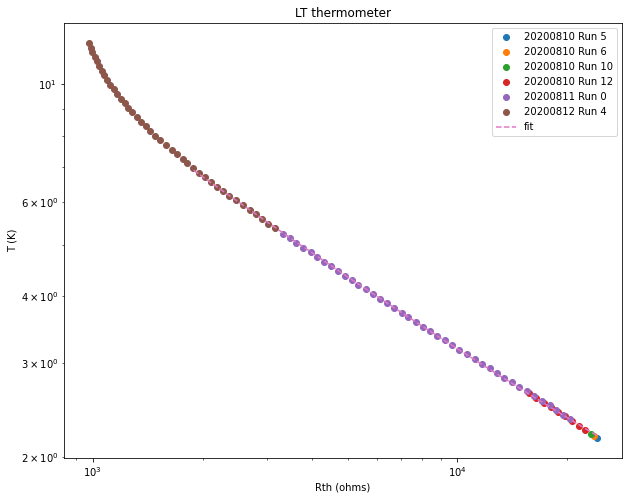

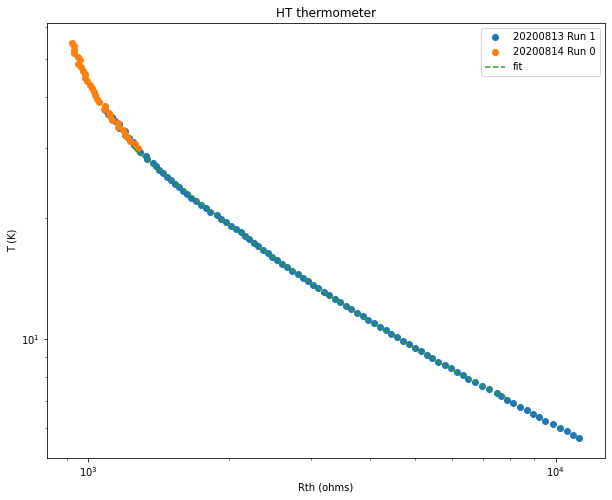

In [4]:
data.get_Rths()

data.do_Rth_fits(cut=True)

The $R_{th}$ data is generally quite clean and easy to fit. The rest of the measurement is not so nice.

## Kappa

You can just press Enter twice when prompted by the following cell.

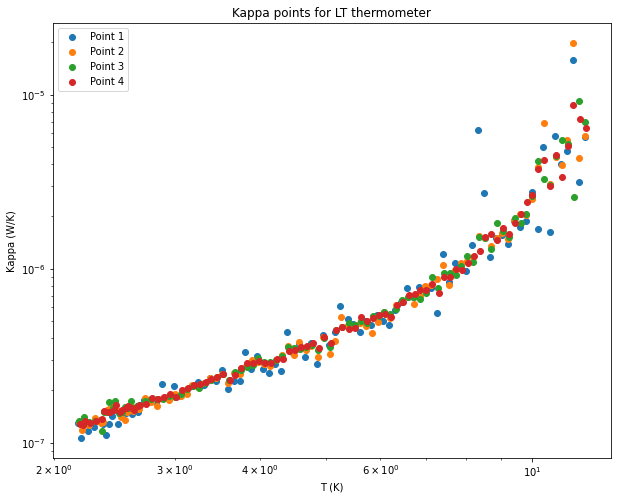

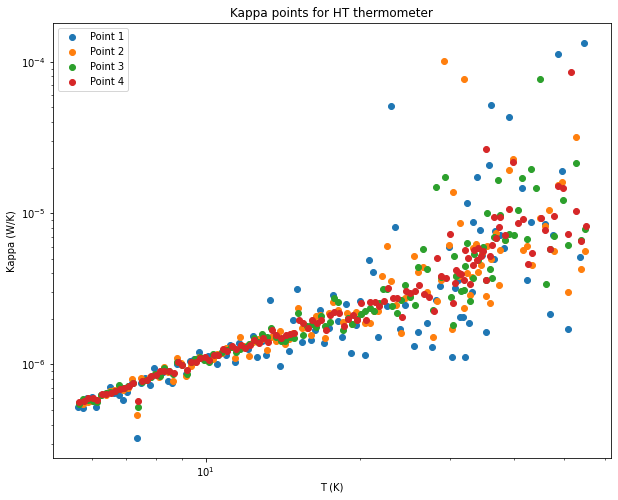

Which points do you want to * drop * for the LT thermometer?
(The default is to keep the highest two.)


Separate them by spaces and then press Enter. 


Which points do you want to * drop * for the HT thermometer?
(The default is to keep the highest two.)


Separate them by spaces and then press Enter. 


In [5]:
data.get_Kappas()

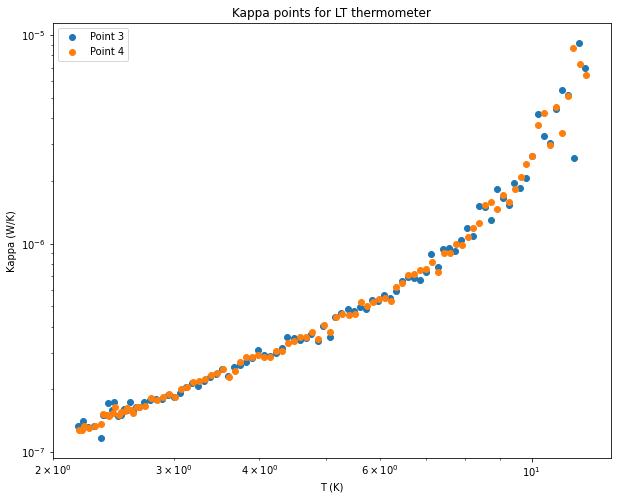

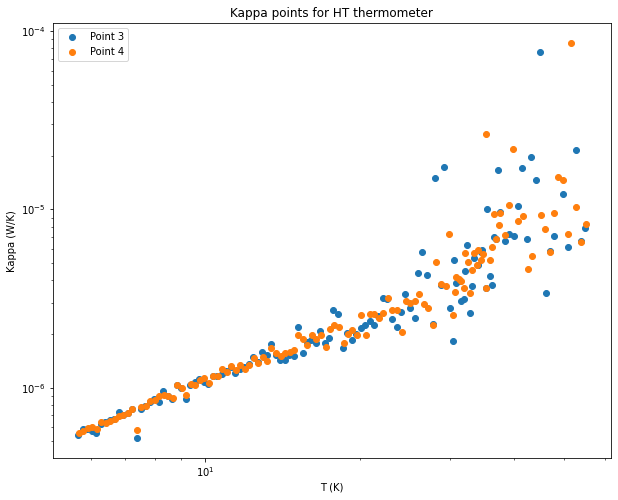

In [6]:
data.plot_dict("Kappa points", plot_type="loglog")

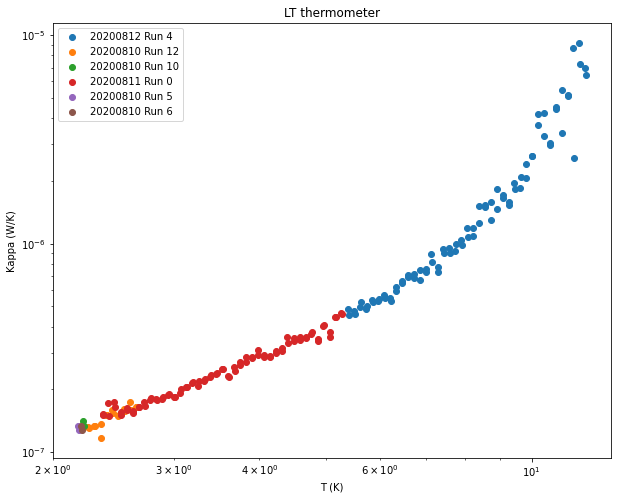

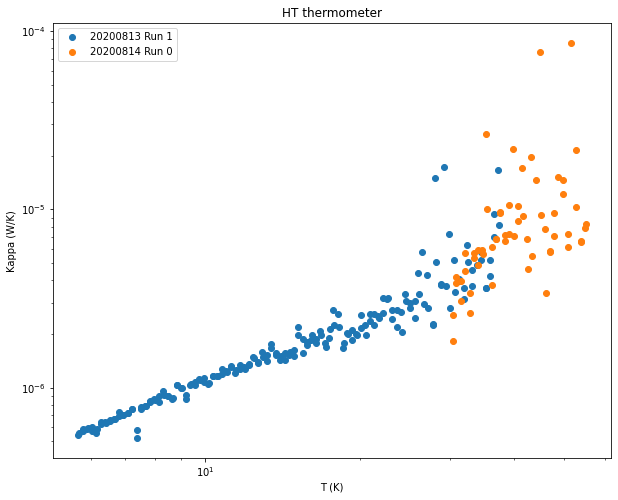

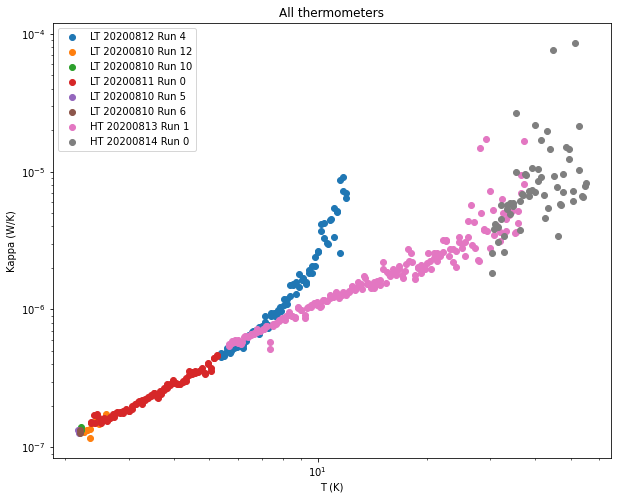

In [7]:
data.plot_dict("Kappa", plot_type="loglog", combine_thermometers=True)

One can see that the LT thermometer starts working quite poorly above about 7 K. There are also serious issues with the HT data above 30 K, likely due to poor temperature stabilization when the block heater power was increased. Thankfully we're only really concerned with what happens below 10 K, though.

Next I will drop a few runs that are problematically noisy and not needed:

LT thermometer: '20200812 Run 4'

HT thermometer: '20200814 Run 0'

In [8]:
drop_list = {}
drop_list['HT thermometer'] = ['20200814 Run 0']
drop_list['LT thermometer'] = ['20200812 Run 4']

In [9]:
data.drop_runs("Kappa", drop_list=drop_list)

LT thermometer 20200812 Run 4 deleted
HT thermometer 20200814 Run 0 deleted


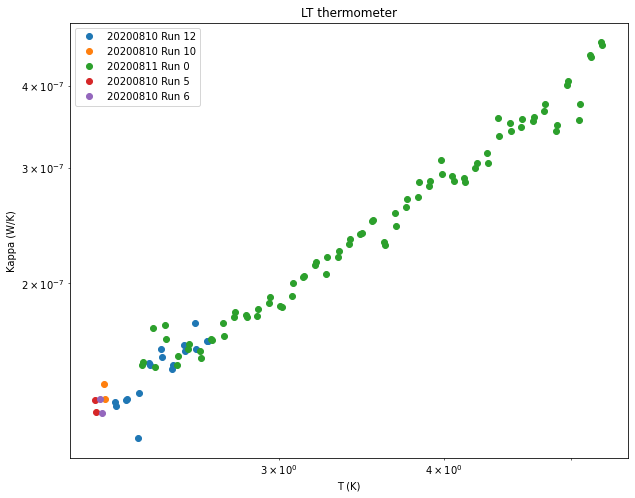

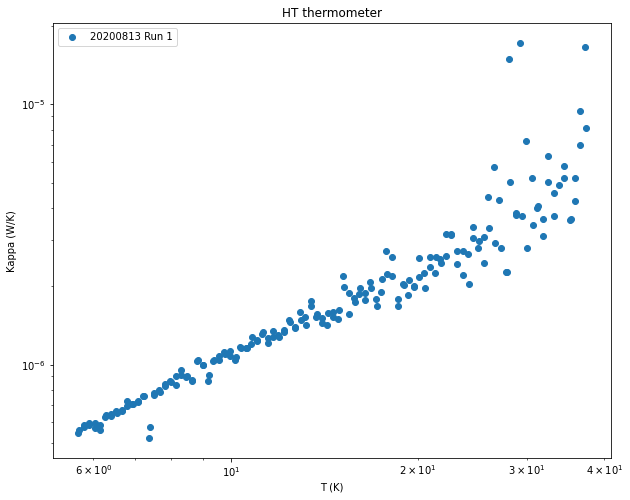

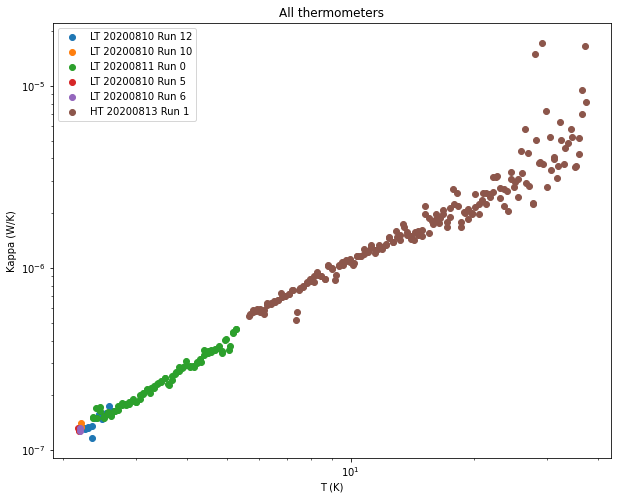

In [10]:
data.plot_dict("Kappa", plot_type="loglog", combine_thermometers=True)

## Tau

The program I wrote to run the measurement does fits to the decays to find $\tau$ and write it to a file in real time. I'll start by just using those files. I do also save the individual decays (typically I did about a hundred decays at each temperature, and I would average these decays and upload the average to Google Drive for additional analysis), and below I will show a simple check on those decays for the LT thermometer, where there are more problems with some noisy decays.

In [11]:
data.get_Taus()

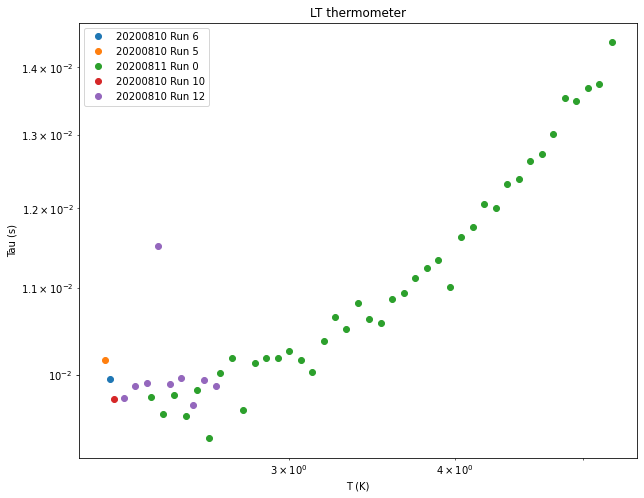

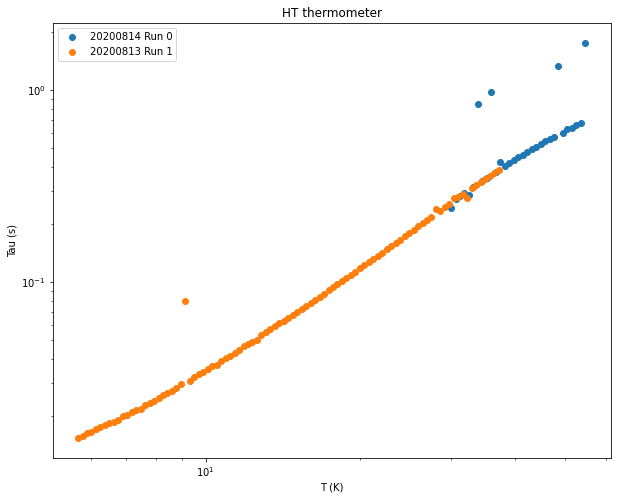

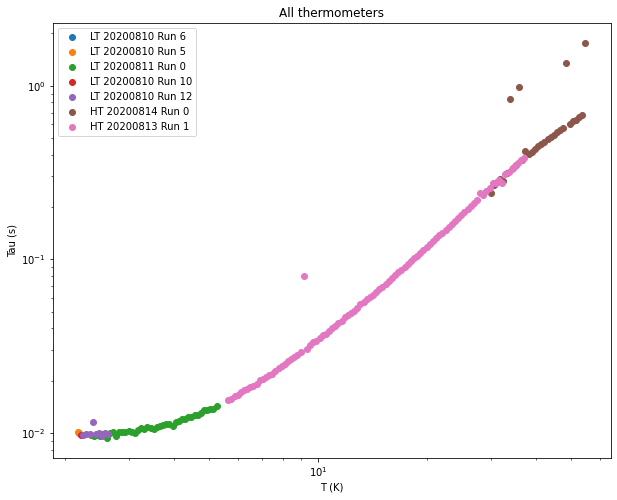

In [12]:
data.plot_dict("Tau", plot_type="loglog", combine_thermometers=True)

Time to do the fits to individual decays (actually, each is an average of many decays at the same temperature). I plot each decay along with its corresponding fit; there are few enough that it's quick to just look through them all, and sometimes one's eyes are the best test for whether something has gone awry. As an objective measure to throw out poor decays, at each temperature I compute the root-mean-square difference error between the decay and the fit and scale this by the vertical size of the decay to get a scaled RMSE. Here I set a cutoff for the scaled RMSE at 1.0 and threw out any decay with fit that exceeds that cutoff (I've noted these decays with some red text).

RMSE cutoff is 1.0


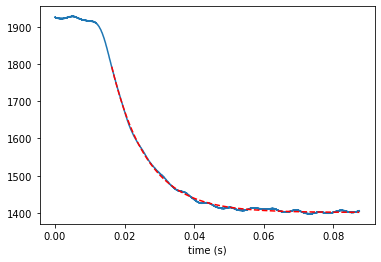

20200810 Run 5: T = 2.19 K, Tau = 0.0102 s with scaled RMSE 0.653







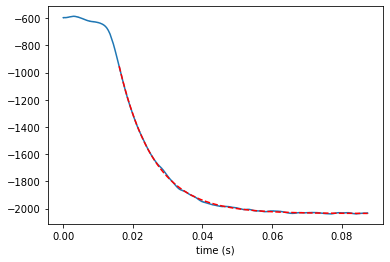

20200810 Run 6: T = 2.21 K, Tau = 0.00996 s with scaled RMSE 0.33







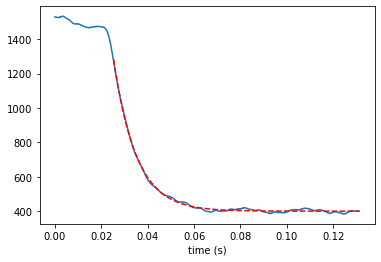

20200810 Run 10: T = 2.22 K, Tau = 0.00977 s with scaled RMSE 0.726







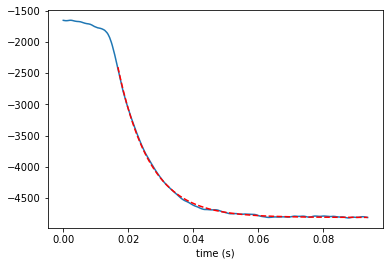

20200810 Run 12: T = 2.26 K, Tau = 0.00979 s with scaled RMSE 0.45







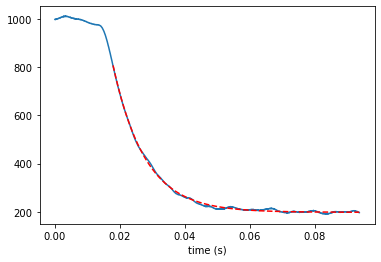

20200810 Run 12: T = 2.31 K, Tau = 0.00989 s with scaled RMSE 0.618







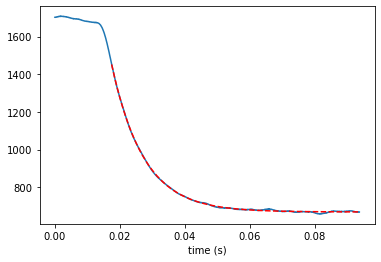

20200810 Run 12: T = 2.35 K, Tau = 0.00991 s with scaled RMSE 0.319







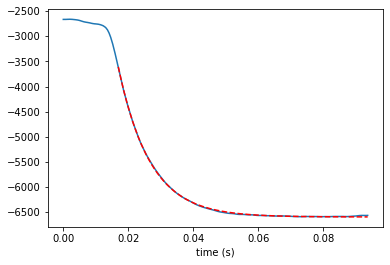

20200811 Run 0: T = 2.37 K, Tau = 0.00977 s with scaled RMSE 0.261







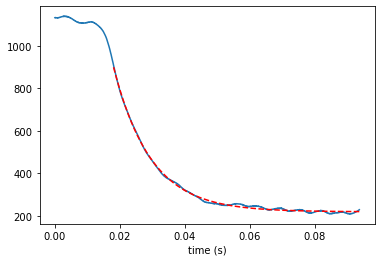

20200810 Run 12: T = 2.4 K, Tau = 0.0115 s with scaled RMSE 0.704







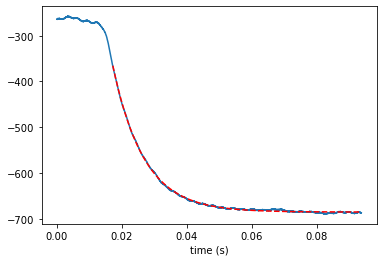

20200811 Run 0: T = 2.42 K, Tau = 0.00959 s with scaled RMSE 0.417







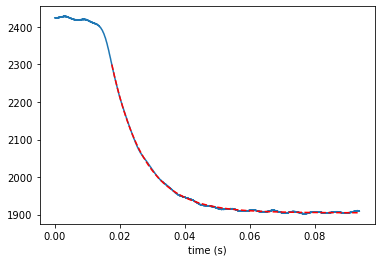

20200810 Run 12: T = 2.45 K, Tau = 0.00991 s with scaled RMSE 0.377







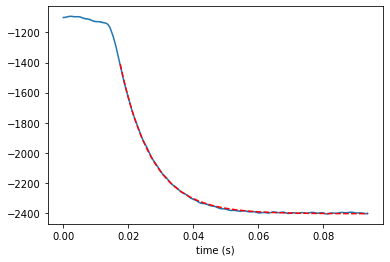

20200811 Run 0: T = 2.47 K, Tau = 0.00982 s with scaled RMSE 0.35







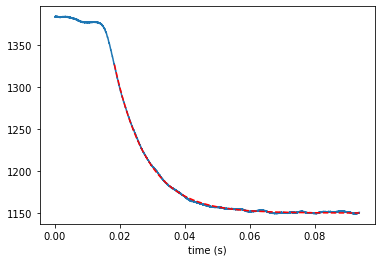

20200810 Run 12: T = 2.5 K, Tau = 0.00999 s with scaled RMSE 0.418







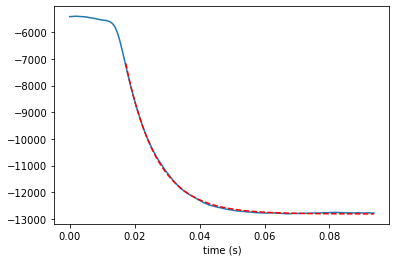

20200811 Run 0: T = 2.52 K, Tau = 0.00961 s with scaled RMSE 0.437







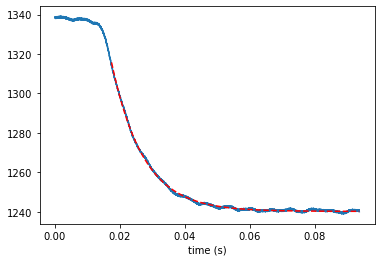

20200810 Run 12: T = 2.55 K, Tau = 0.00975 s with scaled RMSE 0.617







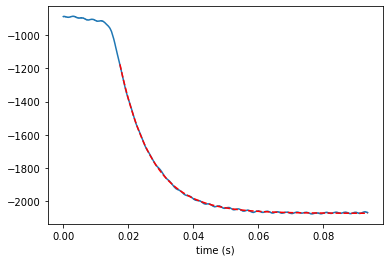

20200811 Run 0: T = 2.57 K, Tau = 0.00984 s with scaled RMSE 0.29







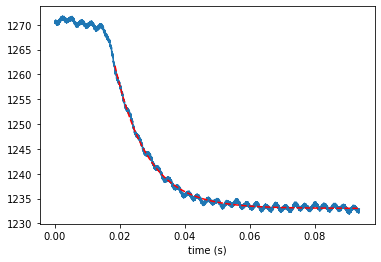

20200810 Run 12: T = 2.6 K, Tau = 0.01 s with scaled RMSE 1.31
 The scaled RMSE is above the cutoff, so this decay won't be included.







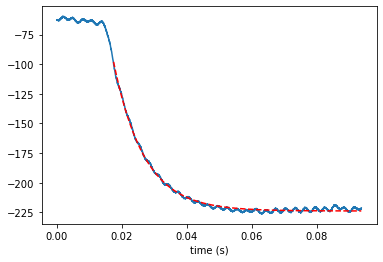

20200811 Run 0: T = 2.62 K, Tau = 0.00941 s with scaled RMSE 1.03
 The scaled RMSE is above the cutoff, so this decay won't be included.







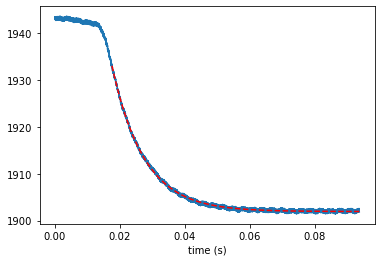

20200810 Run 12: T = 2.66 K, Tau = 0.00989 s with scaled RMSE 0.723







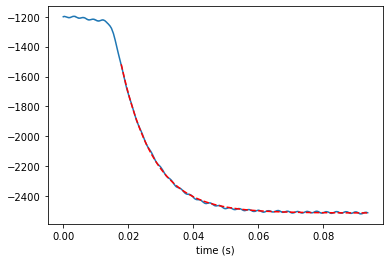

20200811 Run 0: T = 2.68 K, Tau = 0.01 s with scaled RMSE 0.369







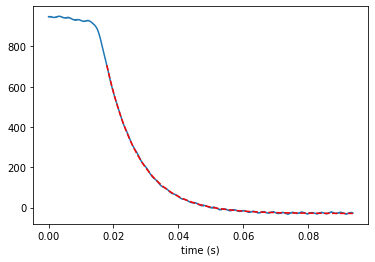

20200811 Run 0: T = 2.73 K, Tau = 0.0102 s with scaled RMSE 0.25







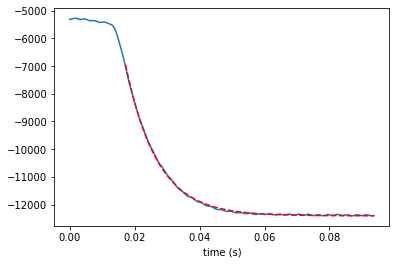

20200811 Run 0: T = 2.79 K, Tau = 0.00969 s with scaled RMSE 0.443







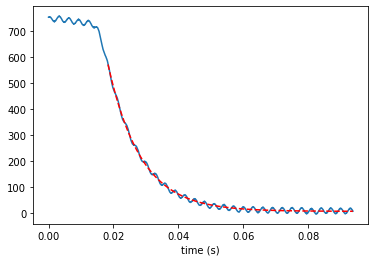

20200811 Run 0: T = 2.84 K, Tau = 0.0101 s with scaled RMSE 0.982







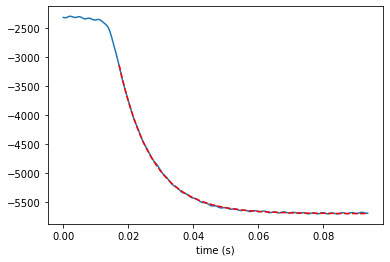

20200811 Run 0: T = 2.9 K, Tau = 0.0102 s with scaled RMSE 0.281







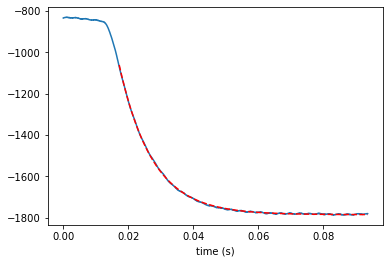

20200811 Run 0: T = 2.96 K, Tau = 0.0102 s with scaled RMSE 0.258







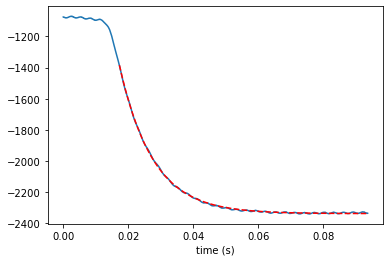

20200811 Run 0: T = 3.02 K, Tau = 0.0103 s with scaled RMSE 0.333







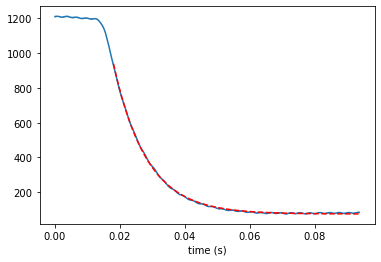

20200811 Run 0: T = 3.08 K, Tau = 0.0102 s with scaled RMSE 0.364







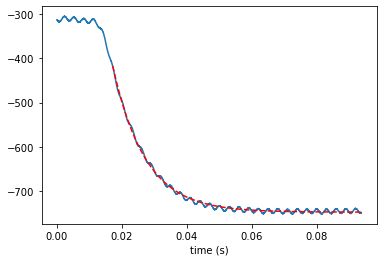

20200811 Run 0: T = 3.14 K, Tau = 0.01 s with scaled RMSE 0.938







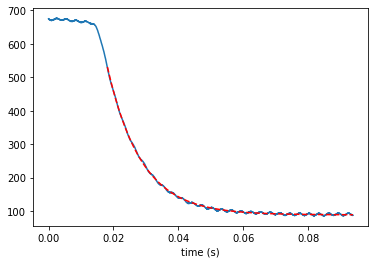

20200811 Run 0: T = 3.21 K, Tau = 0.0104 s with scaled RMSE 0.44







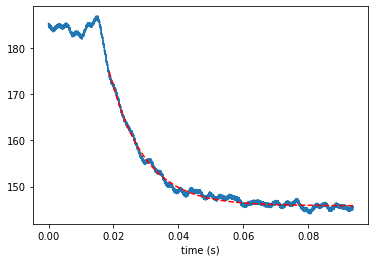

20200811 Run 0: T = 3.27 K, Tau = 0.0107 s with scaled RMSE 1.61
 The scaled RMSE is above the cutoff, so this decay won't be included.







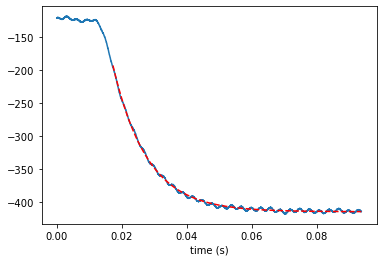

20200811 Run 0: T = 3.34 K, Tau = 0.0105 s with scaled RMSE 0.705







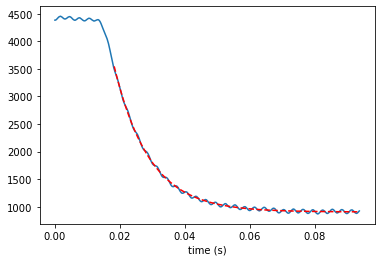

20200811 Run 0: T = 3.4 K, Tau = 0.0109 s with scaled RMSE 0.714







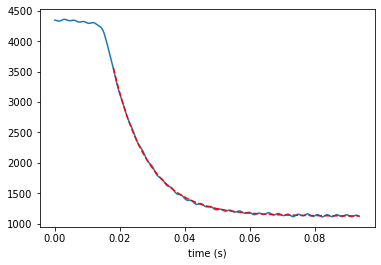

20200811 Run 0: T = 3.47 K, Tau = 0.0107 s with scaled RMSE 0.418







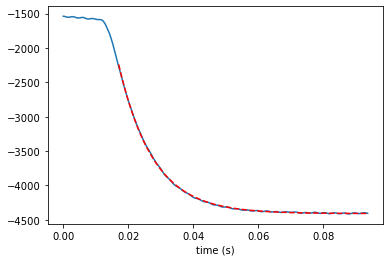

20200811 Run 0: T = 3.54 K, Tau = 0.0106 s with scaled RMSE 0.246







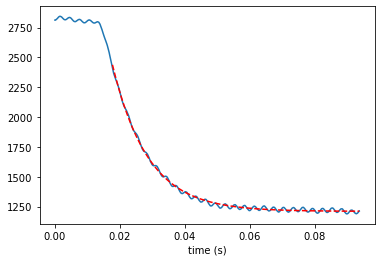

20200811 Run 0: T = 3.62 K, Tau = 0.011 s with scaled RMSE 0.925







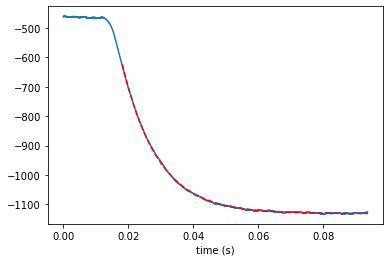

20200811 Run 0: T = 3.69 K, Tau = 0.011 s with scaled RMSE 0.281







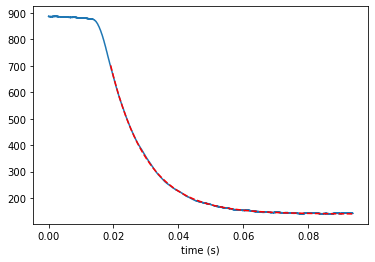

20200811 Run 0: T = 3.76 K, Tau = 0.0112 s with scaled RMSE 0.223







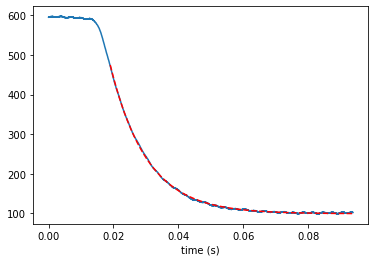

20200811 Run 0: T = 3.84 K, Tau = 0.0113 s with scaled RMSE 0.324







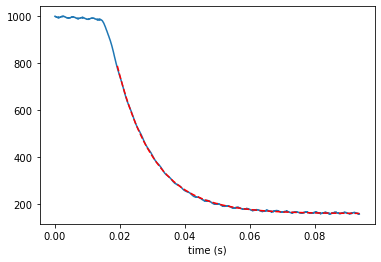

20200811 Run 0: T = 3.92 K, Tau = 0.0114 s with scaled RMSE 0.292







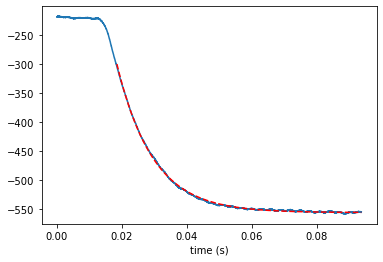

20200811 Run 0: T = 4 K, Tau = 0.0111 s with scaled RMSE 0.428







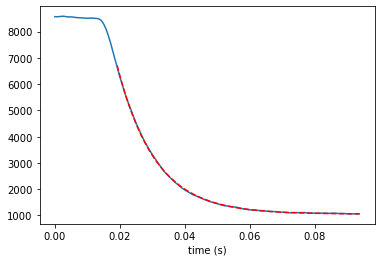

20200811 Run 0: T = 4.08 K, Tau = 0.0117 s with scaled RMSE 0.213







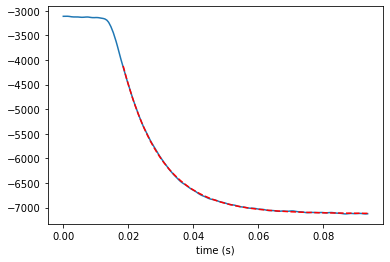

20200811 Run 0: T = 4.16 K, Tau = 0.0118 s with scaled RMSE 0.198







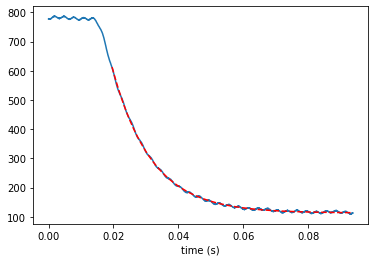

20200811 Run 0: T = 4.24 K, Tau = 0.0121 s with scaled RMSE 0.447







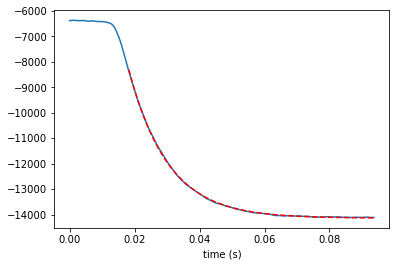

20200811 Run 0: T = 4.33 K, Tau = 0.0121 s with scaled RMSE 0.248







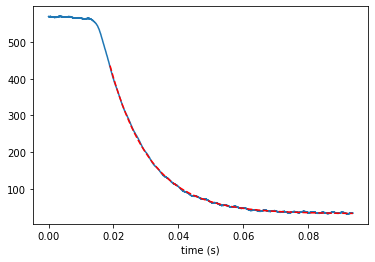

20200811 Run 0: T = 4.42 K, Tau = 0.0124 s with scaled RMSE 0.331







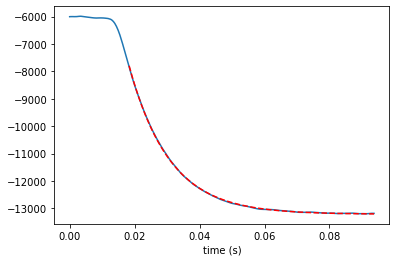

20200811 Run 0: T = 4.51 K, Tau = 0.0124 s with scaled RMSE 0.204







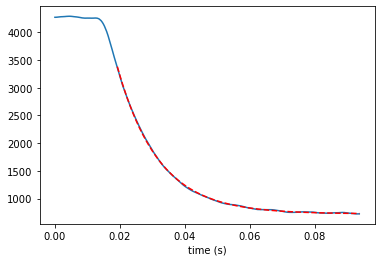

20200811 Run 0: T = 4.6 K, Tau = 0.0127 s with scaled RMSE 0.265







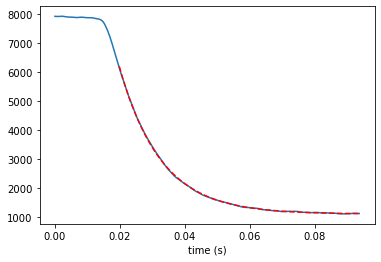

20200811 Run 0: T = 4.69 K, Tau = 0.0128 s with scaled RMSE 0.22







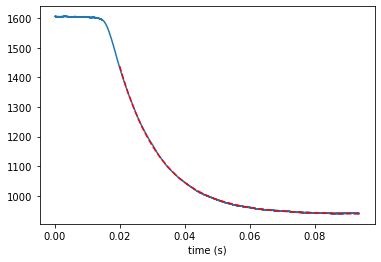

20200811 Run 0: T = 4.79 K, Tau = 0.0131 s with scaled RMSE 0.206







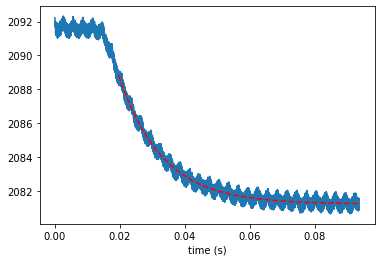

20200811 Run 0: T = 4.88 K, Tau = 0.0134 s with scaled RMSE 2.76
 The scaled RMSE is above the cutoff, so this decay won't be included.







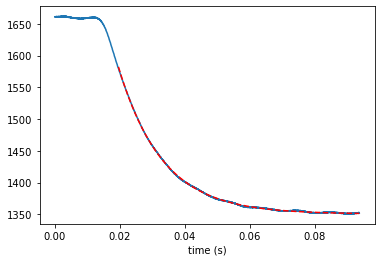

20200811 Run 0: T = 4.98 K, Tau = 0.0135 s with scaled RMSE 0.258







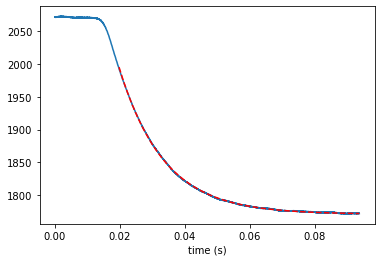

20200811 Run 0: T = 5.08 K, Tau = 0.0137 s with scaled RMSE 0.212







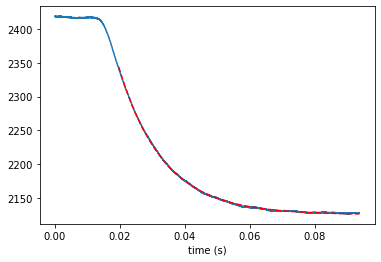

20200811 Run 0: T = 5.19 K, Tau = 0.0138 s with scaled RMSE 0.277







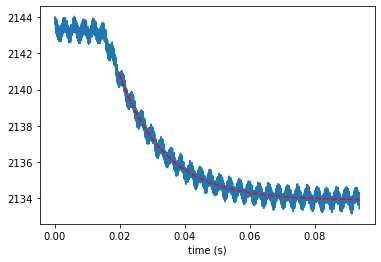

20200811 Run 0: T = 5.29 K, Tau = 0.0142 s with scaled RMSE 3.24
 The scaled RMSE is above the cutoff, so this decay won't be included.







In [13]:
data.get_Tau_fits("LT thermometer", RMSE_cutoff=1.0)

## Some outlier removal

Time to remove some clear outliers. Do do this in a fairly simple way, I made some reasonable spline fits to the data and then threw out points that missed the fit by some threshold.

For the following cell, which removes the Kappa outliers, I recommend just pressing Enter all the way through until it asks "Finished with outlier removal?" the **second** time, and answering "y" to that prompt to finish.

Enter the plot type. Default value is the last value entered, starting with "loglog". 


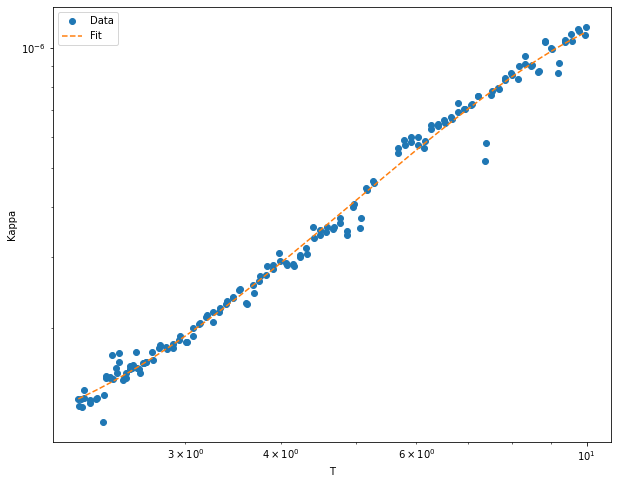

Does s need to be changed? Its current value is 1e-11. Press Enter if it doesn't need to be changed. 
Finished with outlier removal? Enter "y" or "n"; the default is "n". 
Enter the outlier threshold. The default value is 0.1. 


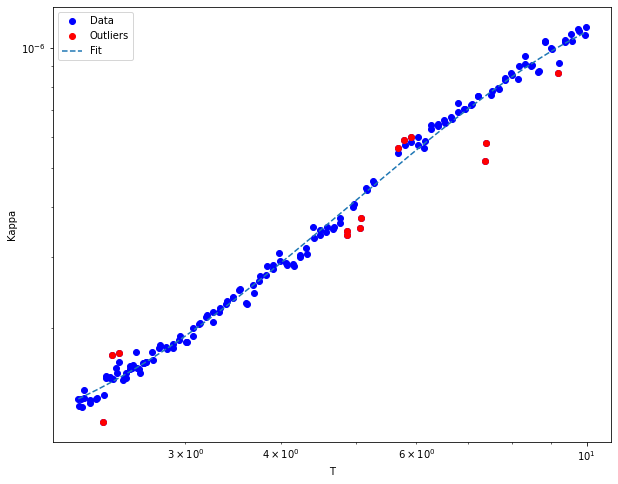

Throw out these points? Answer "y" or "n"; default is "y". 
Enter the plot type. Default value is the last value entered, starting with "loglog". 


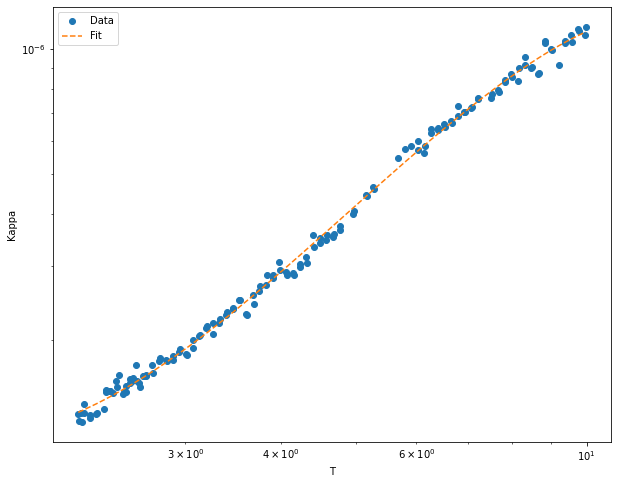

Does s need to be changed? Its current value is 1e-11. Press Enter if it doesn't need to be changed. 
Finished with outlier removal? Enter "y" or "n"; the default is "n". y


In [14]:
input_df = data.Kappa_data["All Data"]
measurement = "Kappa"
T_cut = 10
data.remove_outliers(input_df, measurement, T_cut)

Dealing with the Tau outliers is slightly more involved. I recommend pressing Enter through the whole first round (which will just remove one very bad outlier near 10 K), and then for the second round entering "0.03" as the response to "Enter the outlier threshold," instead of the default of 0.3. Then press Enter until confronted with "Finished with outlier removal?" and answer "y".

Enter the plot type. Default value is the last value entered, starting with "loglog". 


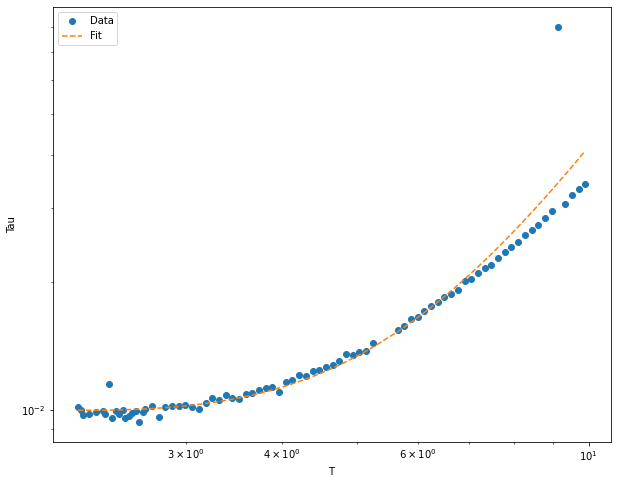

Does s need to be changed? Its current value is 0.01. Press Enter if it doesn't need to be changed. 
Finished with outlier removal? Enter "y" or "n"; the default is "n". 
Enter the outlier threshold. The default value is 0.3. 


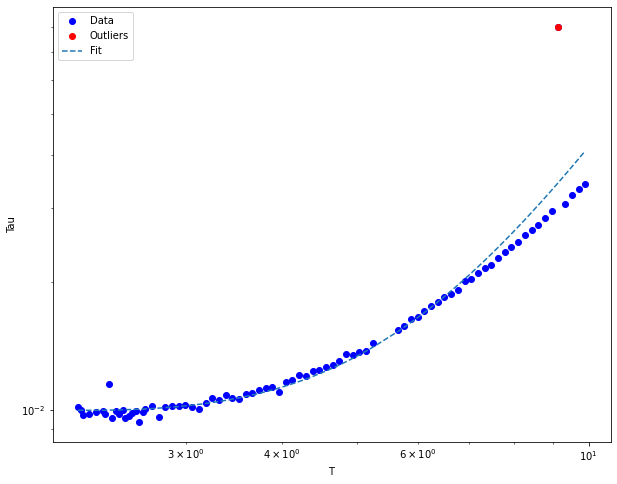

Throw out these points? Answer "y" or "n"; default is "y". 
Enter the plot type. Default value is the last value entered, starting with "loglog". 


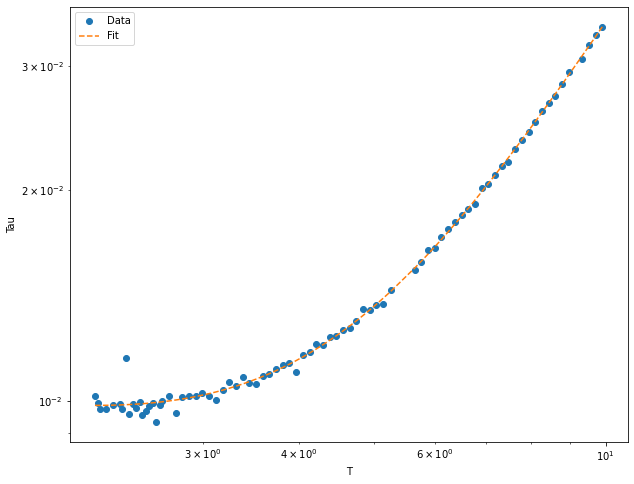

Does s need to be changed? Its current value is 0.01. Press Enter if it doesn't need to be changed. 
Finished with outlier removal? Enter "y" or "n"; the default is "n". 
Enter the outlier threshold. The default value is 0.3. 0.03


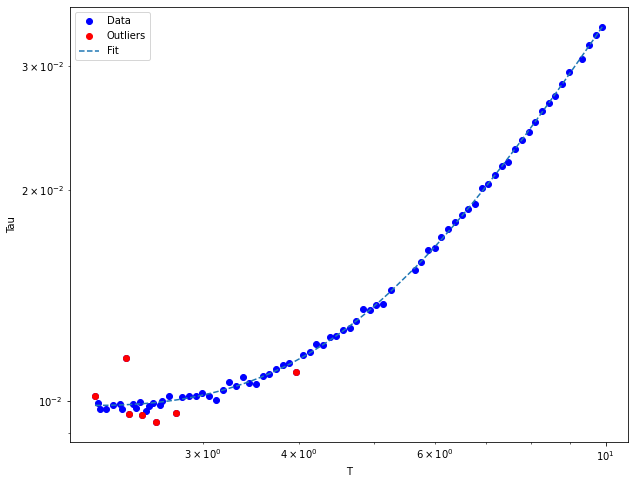

Throw out these points? Answer "y" or "n"; default is "y". 
Enter the plot type. Default value is the last value entered, starting with "loglog". 


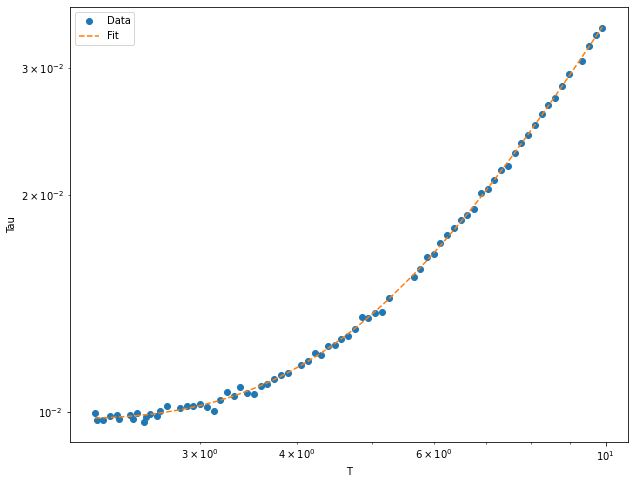

Does s need to be changed? Its current value is 0.01. Press Enter if it doesn't need to be changed. 
Finished with outlier removal? Enter "y" or "n"; the default is "n". y


In [15]:
input_df = data.Tau_data["All Data"]
measurement = "Tau"
T_cut = 10
data.remove_outliers(input_df, measurement, T_cut)

## $C_P$

OK! Now we've found $\kappa$ and $\tau$ curves and done some outlier removal. We need to combine $\kappa$ and $\tau$ to get $C_p$; in order to do this, I will privelege the temperatures at which $\tau$ was measured, interpolating the $\kappa(T)$ curve to find $\kappa$ at these temperatures. Then I need to subtract the heat capacity of the copper layer and the background heat capacity of the microcal itself at these temperatures (two additional interpolations).

First, find Kappa at the temperatures where Tau was measured. The physics I'm interested in for this measurement occurs below 10 K, so I'll cut the data there.

In [27]:
T_cut = 10

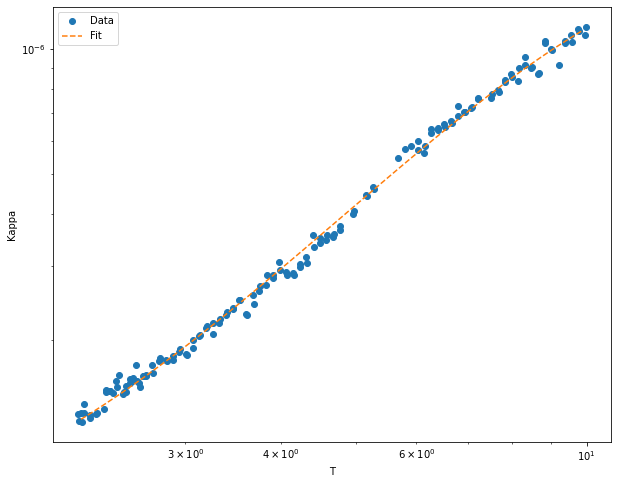

In [28]:
data.get_Kappa_interpolated(T_cut=10)

Now the total heat capacity can be computed.

In [29]:
data.get_total_Cp(T_cut)

Next, fetch the heat capacity of the copper layer and do an interpolation for it as well.

In [30]:
data.get_Cu_Cp()

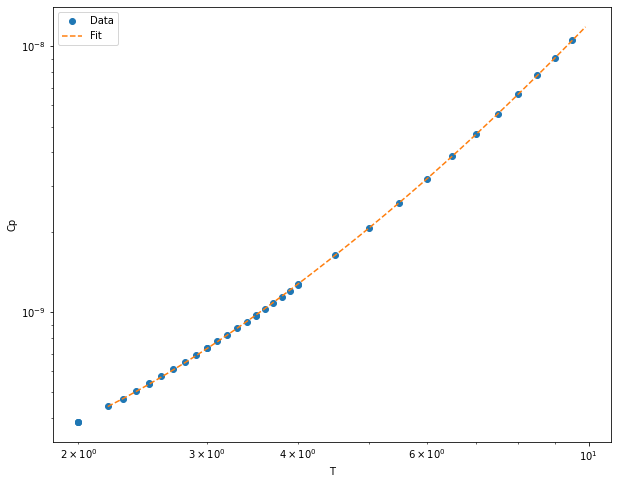

In [31]:
data.get_Cu_Cp_interpolated(T_cut)

Now interpolate the background microcal data to find its heat capacity at the temperatures where Tau was measured.

In [32]:
data.get_background_Cp()

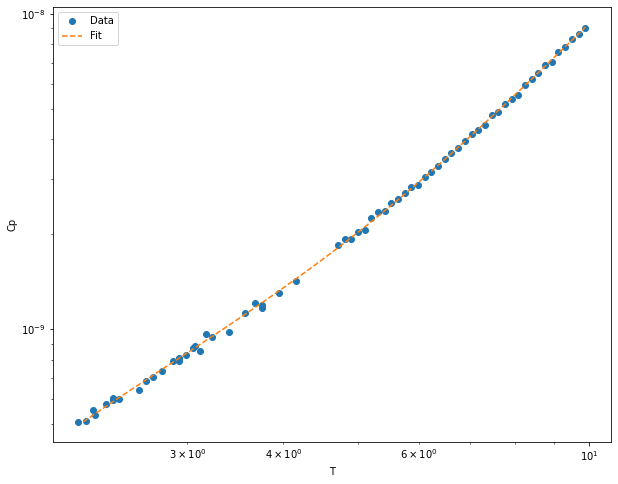

In [33]:
data.get_background_Cp_interpolated(T_cut)

In [34]:
data.get_sample_Cp(T_cut)

A plot of $C_P/T^3$ is quite informative. The physics we are interested in here is called "tunneling model physics," which refers to two-level systems in the glass that quantum tunnel between their states; this dominates the physics at low temperature, including the heat capacity. The heat capacity, in fact, allows us to quantify the density of these systems. The so-called "Standard Tunneling Model" (STM) that takes this physics into account models the low-T heat capacity as

$C_P(T) = c_1 T + c_3 T^3$

where $c_1$ and $c_3$ are constants. So $C_P/T^3 = c_1/T^2 + c_3$, i.e. something that looks like $1/T^2$ plus a constant. But in the plot below we actually see a minimum around 3.5 or 4 K. What this tells us is that tunneling physics is not yet dominant at that temperature (i.e. the STM doesn't apply), and we have to go to slightly lower temperature to see it.

The $T^3$ term is unsurprising and is seen in many materials; it's called the phonon or Debye term. The surprising part is the $T$ term, which dominates the $T^3$ term when the temeprature is low enough. It turns out that its coefficient $c_1$ is directly proportional to the density of states of tunneling two-level systems in the material, which is denoted $n_0$.

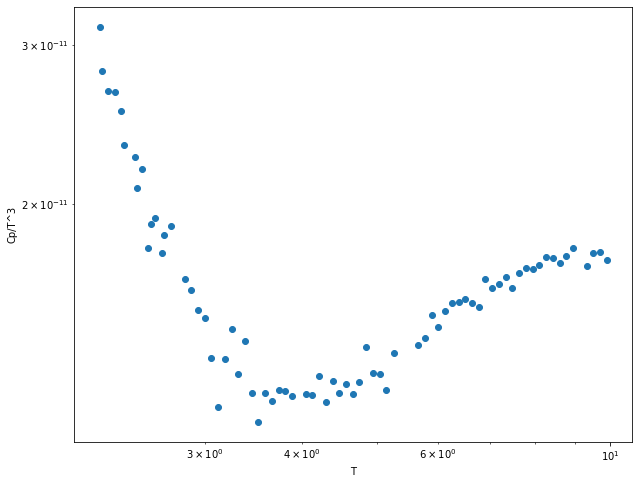

In [35]:
plot_df(data.sample_Cp, "Cp/T^3")

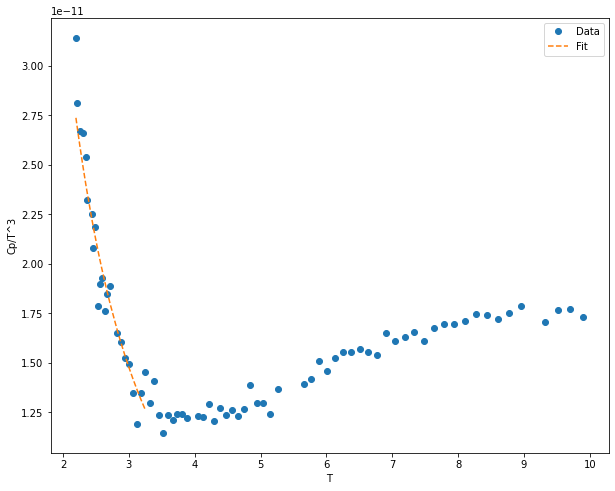

In [36]:
data.get_n0(T_cut=3.3, plot_type="linear")

In [38]:
data.n0

2.064173696801609e+47

This means that the density of states of tunneling two-level systems in the sample is about $2 \times 10^{47}$ per joule per cubic meter; this is considered rather average for a glass. For most glasses, $n_0$ is within a factor of 10 of this value. Using physical vapor deposition with carefully chosen, physically motivated growth conditions, we achieved $n_0$ values several orders of magnitude above and below this in certain materials; this level of control was an unprecedented result.